In [ ]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random

In [9]:
#MNIST Dataset
train_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
print(train_set[0][0].size)
train_loader = torch.utils.data.DataLoader(train_set
    ,batch_size=32
    ,shuffle=True
)

torch.set_printoptions(linewidth=120)

<built-in method size of Tensor object at 0x7f5f3a246b80>


AttributeError: ignored

In [4]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()


In [5]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    #conv1 | input=28*28*1 | output=24*24*6 | RF=5
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    #MP1 | input=24*24*6 | output=12*12*6 | RF=10
    #conv2 | input=12*12*6 | output=8*8*12 | RF=14
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5) 
    #conv3 | input=8*8*12 | output=4*4*32 | RF=18
    self.conv3 = nn.Conv2d(in_channels=12, out_channels=32, kernel_size=5)
    #MP2 | input=4*4*32 | output=2*2*32 | RF=36
    #FC1 | input=2*2*32 | out_features = 32
    self.fc1 = nn.Linear(in_features=32*2*2, out_features=32)
    #Output/MNIST | input=32 | out_features=10
    self.out = nn.Linear(in_features=32, out_features=10)
    #FC2/Sum | input=11 | out_features=19
    self.fc2 = nn.Linear(in_features=11, out_features=19)
  
  def forward(self, t, num, model):
    x = t
    if model == 'mnist':
      # input layer
      
      # conv1 layer
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2, stride=2)
      
      # conv2 layer
      x = self.conv2(x)
      x = F.relu(x)
      
      #conv3 1d conv layer
      x = self.conv3(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2, stride=2)
      
      # reshape
      #print(x.shape)
      x = x.reshape(-1, 32*2*2)
      
      # fc1 layer
      x = self.fc1(x)
      x = F.relu(x)
      
      # fc2 layer
      #x = self.fc2(x)
      #x = F.relu(x)
      
      # output layer
      x = self.out(x)
      #print(x.size())
      #print(num.size())
      #print(torch.transpose(num, 0, 1).size())
    if model=='sum':
      #merge prediction and random number
      x=torch.cat((x, torch.transpose(num, 0, 1)), 1)
      x = self.fc2(x)


    #x = F.softmax(x, dim=1)
    return x

In [6]:
def get_random_num():
  return torch.tensor([[random.randrange(1,10) for i in range(0,32)]])

In [13]:
network = Network()
device = torch.device('cuda')

torch.set_grad_enabled(True)

for epoch in range(30):
    total_loss = 0
    total_correct = 0
    lr = 1/((epoch+1)*(epoch+1)*(epoch+1))
    optimizer = optim.Adam(network.parameters(), 0.001)

    for batch in train_loader: # Get Batch

        images, labels = batch
        rand_num = get_random_num()

        preds_mnist = network(images, rand_num, 'mnist') # Pass Batch
        preds_sum = network(preds_mnist, rand_num, 'sum') # Pass Batch
        #print(labels)
        #print(rand_num[0])
        loss_mnist = F.cross_entropy(preds_mnist, labels) # Calculate Loss
        loss_sum = F.cross_entropy(preds_sum, torch.add(labels, rand_num[0])) # Calculate Loss

        optimizer.zero_grad()
        loss_sum.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss_sum.item()
        total_correct += get_num_correct(preds_sum, torch.add(labels, rand_num[0]))
        #print('loss after batch: '+str(total_loss))
        #print('correct after batch: '+str(total_correct))

    """
    preds = network(images) # Pass Batch
    loss = F.cross_entropy(preds, labels) # Calculate Loss

    optimizer.zero_grad()
    loss.backward() # Calculate Gradients
    optimizer.step() # Update Weights

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)
    """
    print(
        "epoch:", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )


epoch: 0 total_correct: 10390 loss: 4429.671415448189
epoch: 1 total_correct: 18438 loss: 3460.265366077423
epoch: 2 total_correct: 22444 loss: 3116.235142827034
epoch: 3 total_correct: 25308 loss: 2914.4169557094574
epoch: 4 total_correct: 27150 loss: 2776.4529504776
epoch: 5 total_correct: 28924 loss: 2667.3346207141876
epoch: 6 total_correct: 30617 loss: 2578.0346195697784
epoch: 7 total_correct: 31800 loss: 2497.303243994713
epoch: 8 total_correct: 33094 loss: 2432.204349040985
epoch: 9 total_correct: 34154 loss: 2367.8478249311447
epoch: 10 total_correct: 35203 loss: 2316.396575450897
epoch: 11 total_correct: 36276 loss: 2266.422708451748
epoch: 12 total_correct: 37505 loss: 2222.670917034149
epoch: 13 total_correct: 38123 loss: 2174.9415504932404
epoch: 14 total_correct: 38808 loss: 2137.7498277425766
epoch: 15 total_correct: 39911 loss: 2104.5669313669205
epoch: 16 total_correct: 40265 loss: 2068.424749970436
epoch: 17 total_correct: 40849 loss: 2037.6919121742249
epoch: 18 tota

In [14]:
test_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

test_loader = torch.utils.data.DataLoader(test_set
    ,batch_size=1
    ,shuffle=True
)

#print(next(iter(test_loader)))
#image, label = next(iter(test_loader))
#plt.imshow(image.squeeze(), cmap='gray')
#print('label:', label)

In [15]:
image, label = next(iter(test_loader))
network(network(image, None, 'mnist'), 5, 'sum')

TypeError: ignored

label: tensor([2])


tensor(9)

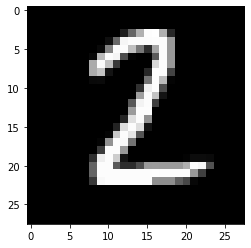

In [18]:
image, label = next(iter(test_loader))
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)
torch.argmax(network(network(image,None, 'mnist'), torch.tensor([[7]]), 'sum'))